In [8]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', None)

# 로그 및 경고 처리
import logging
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append('../../../jupyter_WorkingDirectory/UDM/')
import myLib
import pickle  # pickle 모듈 추가

#Prophet
from prophet import Prophet

# 지리 정보 처리 라이브러리
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc
# ploylt
%matplotlib inline
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# DB Connect
import psycopg2

# Prophet 이란?
- Prophet은 Facebook에서 만든 오픈 소스 시계열 예측 라이브러리입니다.
- 주로 비즈니스 예측에 많이 사용되며, 시간에 따라 변화하는 트렌드, 주간/연간 계절성, 특정 이벤트/휴일 효과 등을 모델링하는 데 강점을 보입니다.
- 주요 특징
    - 쉬운 사용법: Prophet은 사용자가 복잡한 수학적 모델을 이해하지 않아도 간단히 예측을 수행할 수 있습니다.
    - 비선형 추세 모델링: Prophet은 선형 외에도 비선형 추세를 모델링할 수 있습니다.
    - 결측치 및 이상치에 강함: 데이터에 결측치나 이상치가 있어도 비교적 잘 처리할 수 있습니다.
    - 계절성: 주간, 연간 등 다양한 계절성을 자동으로 처리할 수 있습니다.
    - 특수 이벤트: 공휴일, 프로모션 등의 이벤트를 반영할 수 있습니다.

## Prophet 내부 수학(GAM) 개요
- Prophet은 **Generalized Additive Model(GAM)** 기반으로, 시계열 관측치 $y(t)$를 다음 네 가지 합으로 모델링합니다:
  $$
  y(t) = g(t) + s(t) + h(t) + \varepsilon_t
  $$
- $g(t)$: 추세 함수 (trend)  
- $s(t)$: 계절성 함수 (seasonality)  
- $h(t)$: 휴일(holiday) 효과  
- $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$$: 독립 동분산 오차  

### 3-1. 추세 함수 $g(t)$

1. **선형(linear) 성장**  
   $$
   g(t) = k \, t + m
   $$
   - $k$: 성장속도 (growth rate)  
   - $m$: 절편 (intercept)  

2. **로지스틱(logistic) 성장**  
   $$
   g(t) = \frac{C}{1 + \exp\bigl(-k(t - t_0)\bigr)}
   $$
   - $C$: 용량 (capacity, saturation)  
   - $t_0$: 중심점 (center)  
   - 모델 학습 시, 데이터프레임에 `cap`·`floor` 열을 추가하여 사용  

3. **Changepoints 처리**  
   - $S$개의 changepoint $\{\tau_j\}$에서 성장속도 변화량 $\delta_j$ 도입  
     $$
     g(t) = \Bigl(k + \sum_{j:\,\tau_j < t} \delta_j\Bigr)\,t 
            \;+\; \Bigl(m - \sum_{j:\,\tau_j < t} \delta_j\,\tau_j\Bigr)
     $$
   - $\delta_j$에 Laplace 사전분포 적용 → `changepoint_prior_scale`로 제어  

### 3-2. 계절성 함수 $s(t)$
Fourier 급수(fourier series)로 표현:

$$
s(t) = \sum_{n=1}^{N} \Bigl[a_n \cos\!\bigl(\tfrac{2\pi n t}{P}\bigr) + b_n \sin\!\bigl(\tfrac{2\pi n t}{P}\bigr)\Bigr]
$$

- **내장 계절성**  
  - 연간: $P=365.25, N=10$  
  - 주간: $P=7, N=3$  
  - 일간: $P=1, N=3$  
- **사용자 정의**  
  ```python
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  ```
### 3-3. 휴일 효과 함수 $h(t)$
휴일 리스트 $H = \{d_h\}$에 따라:

$$
h(t) = \sum_{h \in H} \alpha_h \, I_h(t)
$$

- $I_h(t)$: 지표 함수, $t$가 휴일 $d_h$이면 1, 아니면 0  
- $\alpha_h$: 휴일 효과 크기 (impact)  
- `m.add_country_holidays('KR')` 또는 커스텀 휴일 데이터프레임으로 확장 가능  
- 휴일 효과에도 Laplace 사전분포 적용 → 과적합 억제
### 3-4. 파라미터 추정 및 불확실성
- **MAP 추정**: Stan 백엔드를 이용해 최대 a posteriori 점 추정  
- **불확실성 샘플링**:  
  - `uncertainty_samples` 개수만큼 시뮬레이션  
  - `interval_width`로 예측 구간 폭 조정  
### 3-5. 외부 회귀변수(회귀항) 통합
GAM 구조를 활용하여:

$$
y(t) = g(t) + s(t) + h(t) + \sum_{k} \beta_k \, X_k(t) + \varepsilon_t
$$

- `m.add_regressor('temp')` 등으로 회귀변수 추가  
- 스케일링·결측치 처리 필수  
- 회귀계수 $\beta_k$는 Gaussian 사전분포 아래 학습  


# Prophet의 기본 사용법과 원리 이해
- Prophet은 두 개의 주요 컬럼(ds, y)이 포함된 데이터 프레임을 입력받습니다.
- ds: 날짜/시간을 나타내는 컬럼 (타입: datetime)
- y: 예측하려는 값 (타입: float)

In [13]:
# 데이터 준비
df = pd.DataFrame({
    'ds': pd.to_datetime(pd.date_range(start='2021-01-01',end='2021-10-31')),
    'y': np.random.randint(100,500,size=len(pd.date_range(start='2021-01-01',end='2021-10-31')))
})

# 모델 생성
model = Prophet()

# 모델 학습
model.fit(df)

# 예측할 날짜 생성 (예: 1일 후 예측)
future = model.make_future_dataframe(periods=61)

# 예측
forecast = model.predict(future)

2025-04-04 11:04:37,225 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 11:04:37,226 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 11:04:37,230 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/h2m3yt6d.json
2025-04-04 11:04:37,232 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/gefbsm_o.json
2025-04-04 11:04:37,233 - DEBUG - idx 0
2025-04-04 11:04:37,233 - DEBUG - running CmdStan, num_threads: None
2025-04-04 11:04:37,233 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13519', 'data', 'file=/tmp/tmp1zhw1ynh/h2m3yt6d.json', 'init=/tmp/tmp1zhw1ynh/gefbsm_o.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelue87rcha/prophet_model-20250404110437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 11:04:37,233 - INFO - C

- yhat: 예측값
- yhat_lower: 예측값의 하한 (신뢰 구간)
- yhat_upper: 예측값의 상한 (신뢰 구간)

In [14]:
# 예측 결과 출력
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,285.814611,139.663936,441.276628
1,2021-01-02,292.603576,141.386608,453.732999
2,2021-01-03,303.168972,153.273530,449.546788
3,2021-01-04,311.328301,148.139643,465.663021
4,2021-01-05,338.763578,185.835658,491.428984
...,...,...,...,...
360,2021-12-27,302.594813,149.538070,469.609942
361,2021-12-28,330.030090,170.744496,483.324295
362,2021-12-29,275.049708,127.541484,432.146903
363,2021-12-30,290.029594,142.382101,444.082147


## 모델의 구성요소 및 하이퍼파라미터 조정
- 다음 단계에서는 Prophet 모델의 세부적인 구성 요소와 하이퍼파라미터 조정에 대해 배워보겠습니다.
1. 추세(Trend) 조정
    - Prophet은 기본적으로 선형 추세를 모델링합니다.
    - 그러나 데이터가 급격하게 변화하는 경우, 로지스틱 추세를 사용할 수 있습니다.
    - 로지스틱 추세를 사용하려면 growth='logistic' 옵션을 추가하고, cap(상한) 값을 설정해야 합니다.
2. 계절성(Seasonality) 조정
    - Prophet은 기본적으로 연간, 주간 계절성을 자동으로 모델링합니다. 추가적으로 사용자 정의 계절성을 설정할 수도 있습니다.
3. 휴일(Holidays) 효과 반영
    - 공휴일이나 특정 이벤트가 예측에 중요한 영향을 미칠 경우, 이를 모델에 반영할 수 있습니다.
    - 예를 들어, 크리스마스와 같은 공휴일을 반영하려면 아래와 같이 휴일을 설정할 수 있습니다.

## Prophet의 내부 휴일(Holidays) 설정 메서드
- Prophet은 미리 정의된 휴일을 제공하는 함수가 기본적으로 내장되어 있지는 않지만, ***add_country_holidays*** 라는 메서드를 이용하여 특정 국가의 주요 공휴일을 Prophet 모델에 쉽게 추가할 수 있습니다.

In [15]:
# 모델 생성
model = Prophet()

# 국가별 휴일 자동 추가 (예: 한국의 공휴일)
model.add_country_holidays(country_name='KR')

# 모델 학습
model.fit(df)

2025-04-04 13:58:26,250 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 13:58:26,251 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 13:58:26,258 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/9lezs05q.json
2025-04-04 13:58:26,263 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/5cx3g2p4.json
2025-04-04 13:58:26,264 - DEBUG - idx 0
2025-04-04 13:58:26,264 - DEBUG - running CmdStan, num_threads: None
2025-04-04 13:58:26,264 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18097', 'data', 'file=/tmp/tmp1zhw1ynh/9lezs05q.json', 'init=/tmp/tmp1zhw1ynh/5cx3g2p4.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelwp_hmlf9/prophet_model-20250404135826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:58:26 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 13:58:26,264 - INFO - C

In [16]:
# 추가된 휴일 목록 확인
model.train_holiday_names

0                                      New Year's Day
1                                     Korean New Year
2                   The day preceding Korean New Year
3                   The second day of Korean New Year
4                           Independence Movement Day
5                                   Buddha's Birthday
6                                      Children's Day
7                                        Memorial Day
8                                      Liberation Day
9                             National Foundation Day
10                                         Hangul Day
11                                            Chuseok
12                          The day preceding Chuseok
13                          The second day of Chuseok
14                                      Christmas Day
15             Alternative holiday for Liberation Day
16    Alternative holiday for National Foundation Day
17                 Alternative holiday for Hangul Day
dtype: object

In [22]:
# 데이터 준비 (랜덤 데이터 예시)
df = pd.DataFrame({
    'ds': pd.date_range(start='2021-01-01', end='2021-10-31'),
    'y': np.random.randint(100, 500, size=len(pd.date_range(start='2021-01-01', end='2021-10-31')))
})

# 모델 생성 및 휴일 추가 (한국)
model = Prophet()
model.add_country_holidays(country_name='KR')

# 모델 학습
model.fit(df)

# 예측할 미래 날짜 생성
future = model.make_future_dataframe(periods=61) #연말까지

# 예측
forecast = model.predict(future)

# 예측 결과 확인 (마지막 30일)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))

2025-04-04 14:02:01,353 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 14:02:01,353 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 14:02:01,360 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/csd6d4hb.json
2025-04-04 14:02:01,365 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/pnx1ua4l.json
2025-04-04 14:02:01,365 - DEBUG - idx 0
2025-04-04 14:02:01,365 - DEBUG - running CmdStan, num_threads: None
2025-04-04 14:02:01,365 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82932', 'data', 'file=/tmp/tmp1zhw1ynh/csd6d4hb.json', 'init=/tmp/tmp1zhw1ynh/pnx1ua4l.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelc0vj6w51/prophet_model-20250404140201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:02:01 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 14:02:01,366 - INFO - C

,ds,yhat,yhat_lower,yhat_upper
360,2021-12-27,284.235251,140.749733,428.603000
361,2021-12-28,298.427374,156.505627,438.559804
362,2021-12-29,298.929881,169.504369,448.957312
363,2021-12-30,271.139302,130.373174,412.716524
364,2021-12-31,280.451420,131.070415,414.742517


## 공식 튜토리얼 예제

In [3]:
# 공식 튜토리얼 Airline Passengers 데이터
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


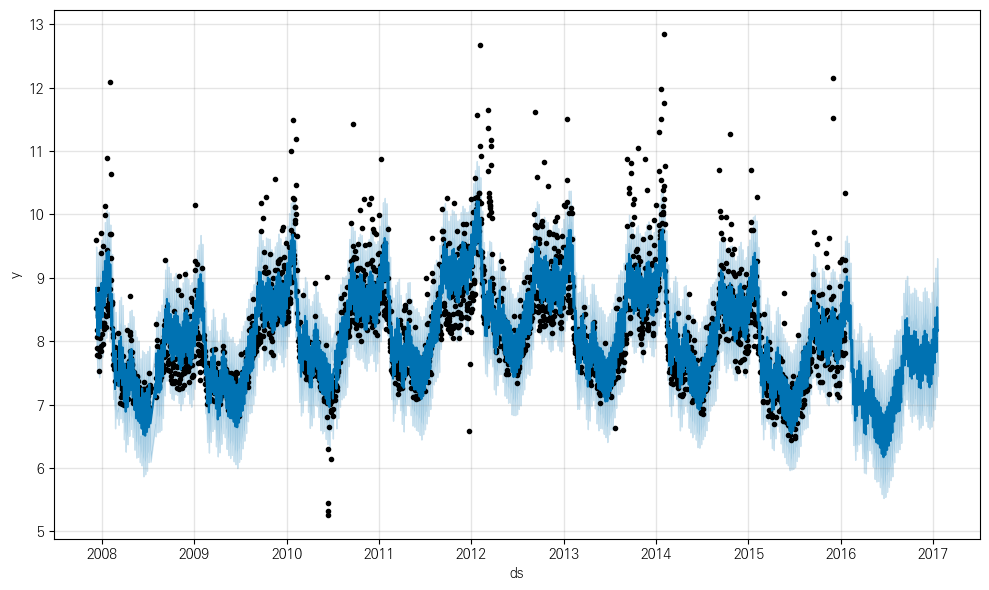

In [4]:
## 1-3. 모델 학습 및 예측
m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.show()

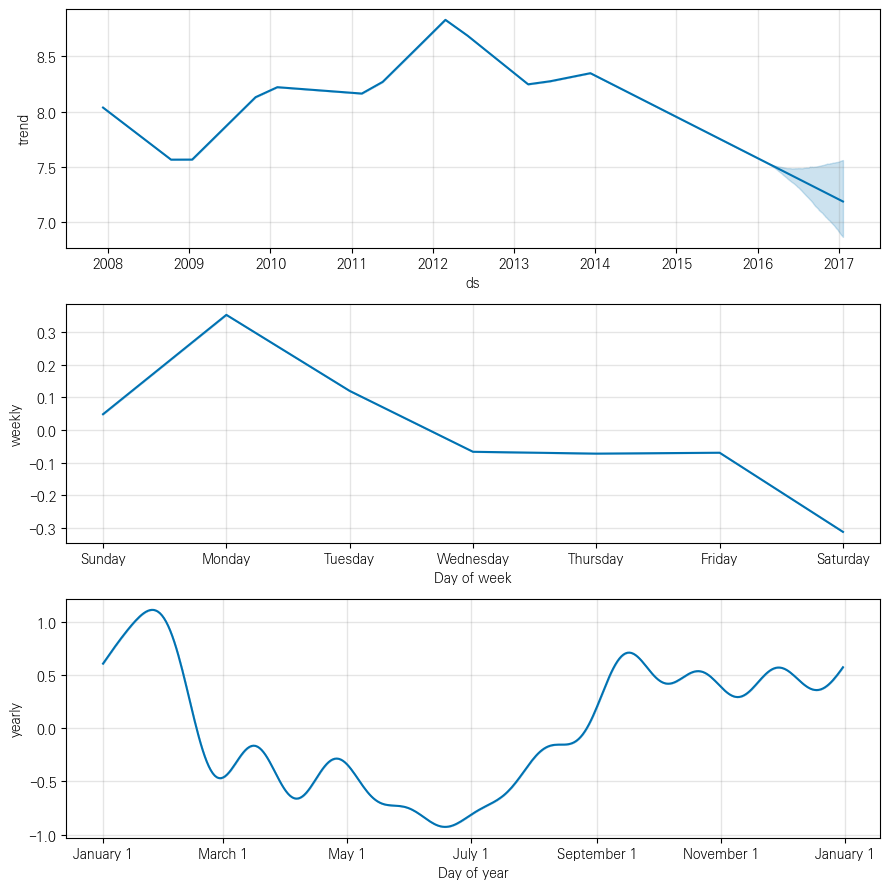

In [7]:
## 1-4. 컴포넌트 시각화
m.
fig2 = m.plot_components(forecast)
plt.show()

# Prophet의 심층적 활용 및 결과 해석

## 📌 1. 예측 결과 시각화 (model.plot())
model.plot() 메서드를 사용하여 Prophet의 예측 결과를 시각화할 수 있습니다. 이 메서드는 예측된 데이터와 실제 데이터를 시각적으로 비교해줍니다.

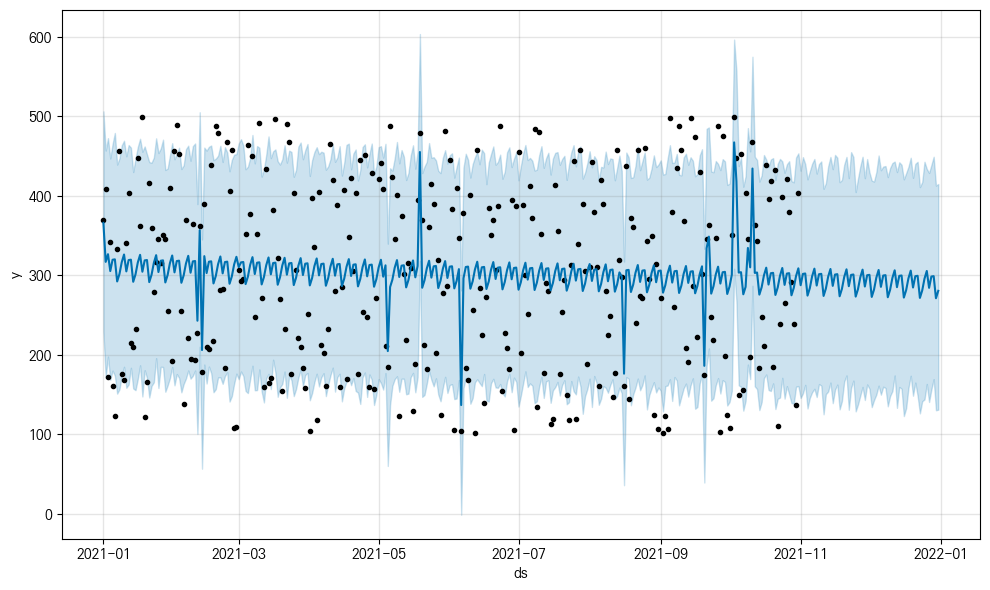

In [37]:
# 예측 결과 시각화
fig = model.plot(forecast)
plt.show()

## 📌 2. Prophet의 구성 요소 시각화 (model.plot_components())
- model.plot_components() 메서드는 예측 결과를 구성하는 다양한 요소(추세, 계절성, 휴일 효과 등)를 개별적으로 시각화합니다.
- Prophet 모델에서 추세와 계절성을 시각적으로 분석할 수 있는 유용한 방법입니다.
### 구성 요소 분석
- 추세(Trend): 데이터의 전반적인 상승/하강 추세를 보여줍니다.
- 주간(Weekly) 및 연간(Yearly) 계절성: 주간 및 연간 패턴을 분리하여 시각화합니다.
- 휴일 효과(Holidays): 지정된 휴일이 예측에 미친 영향을 보여줍니다.
이 메서드를 통해 예측의 각 구성 요소가 어떻게 모델에 반영되었는지 분석할 수 있습니다.

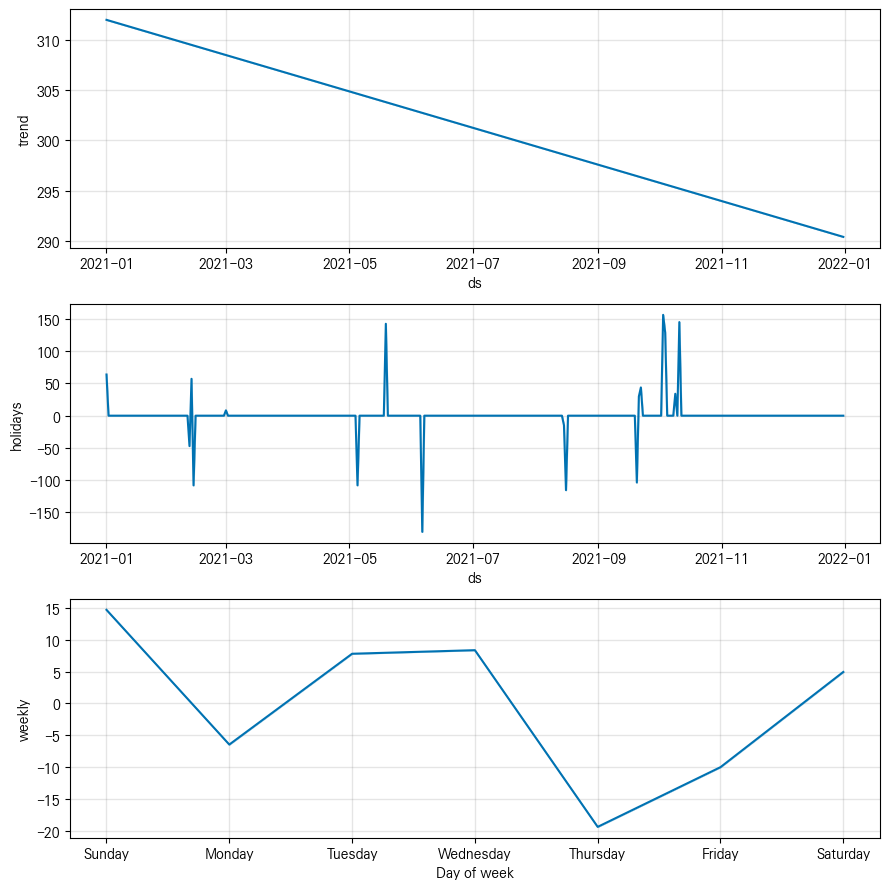

In [38]:
# Prophet의 각 구성 요소 (추세, 계절성 등) 시각화
fig2 = model.plot_components(forecast)
plt.show()

## 📌 3. add_changepoints_to_plot을 사용하여 Prophet 예측 그래프에 변화점(changepoints)을 추가

- add_changepoints_to_plot는 Prophet이 예측하는 동안 찾은 **변화점(changepoints)** 을 시각화하여 추세가 변하는 지점을 확인할 수 있도록 해줍니다.

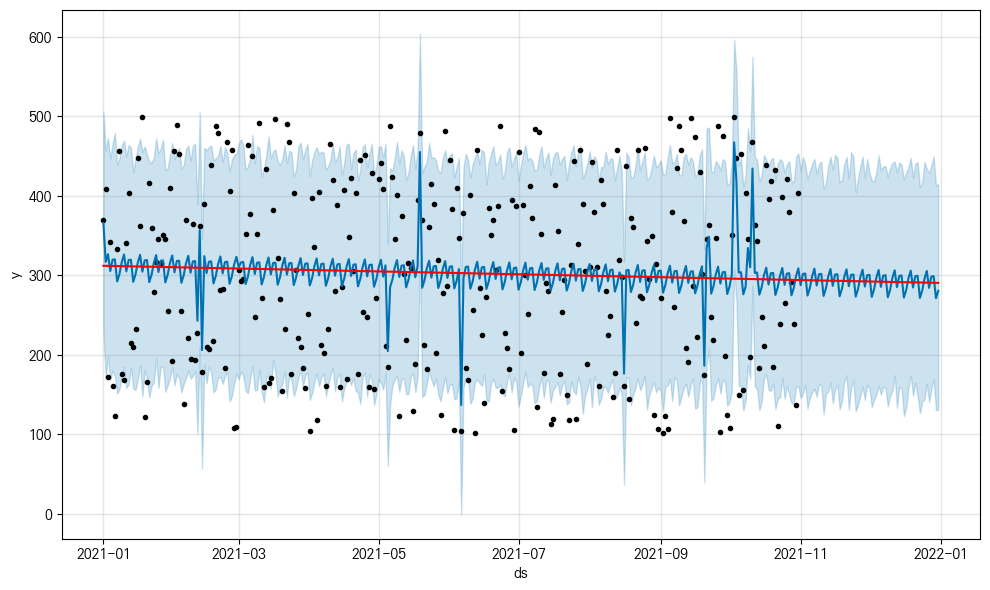

In [41]:
from prophet.plot import add_changepoints_to_plot

# 예측 결과 시각화 (전체 예측)
fig = model.plot(forecast)

# 변화점 추가 (추세가 바뀌는 지점 표시)
add_changepoints_to_plot(fig.gca(), model, forecast)

# 그래프 출력
plt.show()

# Prophet 모델 고급 기능 및 성능 최적화

## 📌1. 변수 추가 및 다변량 예측 (Regressors 사용)
- 이론적 배경
    - Prophet은 단변량 시계열 예측에 최적화되어 있지만, 다변량 시계열 예측을 할 수 있도록 외부 변수를 추가할 수 있습니다.
    - 이를 통해 Prophet은 다른 예측에 영향을 미치는 외부 요인들을 반영할 수 있습니다.
    - 외부 변수 (External Regressors)
        - 외부 변수는 Prophet 모델에 추가되어 예측값에 영향을 미치는 변수들입니다. 예를 들어, 날씨, 마케팅 캠페인, 경제 지표 등이 될 수 있습니다.
    - Regressor 추가 방법
        - add_regressor() 메서드를 사용하여 외부 변수를 모델에 추가할 수 있습니다.
        - Prophet은 이 변수를 시계열 예측 모델에 통합하여 예측 정확도를 향상시킬 수 있습니다.
- 이론적인 설명
    - 외부 변수 (External Regressors): Prophet은 기본적으로 단변량 시계열 예측에 적합하지만, 외부 변수(예: 날씨, 경제 지표, 마케팅 캠페인 등)를 추가하여 다변량 시계열 예측을 할 수 있습니다. 외부 변수는 예측에 영향을 미치는 요인들을 모델에 반영하여 예측 정확도를 높이는 데 도움을 줍니다.
    - 선형 회귀 모델 (Linear Regression): Prophet은 내부적으로 선형 회귀 모델을 사용하여 추세를 예측합니다. 외부 변수를 추가하면, Prophet은 이 외부 변수와 예측 대상 변수 간의 관계를 학습하여 예측에 반영합니다.
    - add_regressor() 메서드: Prophet 모델에 외부 변수를 추가하는 데 사용됩니다. 이 메서드를 사용하면 외부 변수를 Prophet 모델에 추가하여 예측 정확도를 향상시킬 수 있습니다.

2025-04-04 15:28:24,178 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:28:24,179 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:28:24,183 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/2r8barhs.json
2025-04-04 15:28:24,186 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/y1h3elsu.json
2025-04-04 15:28:24,186 - DEBUG - idx 0
2025-04-04 15:28:24,186 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:28:24,186 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24309', 'data', 'file=/tmp/tmp1zhw1ynh/2r8barhs.json', 'init=/tmp/tmp1zhw1ynh/y1h3elsu.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelx5ozyrcw/prophet_model-20250404152824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:24 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:28:24,186 - INFO - C

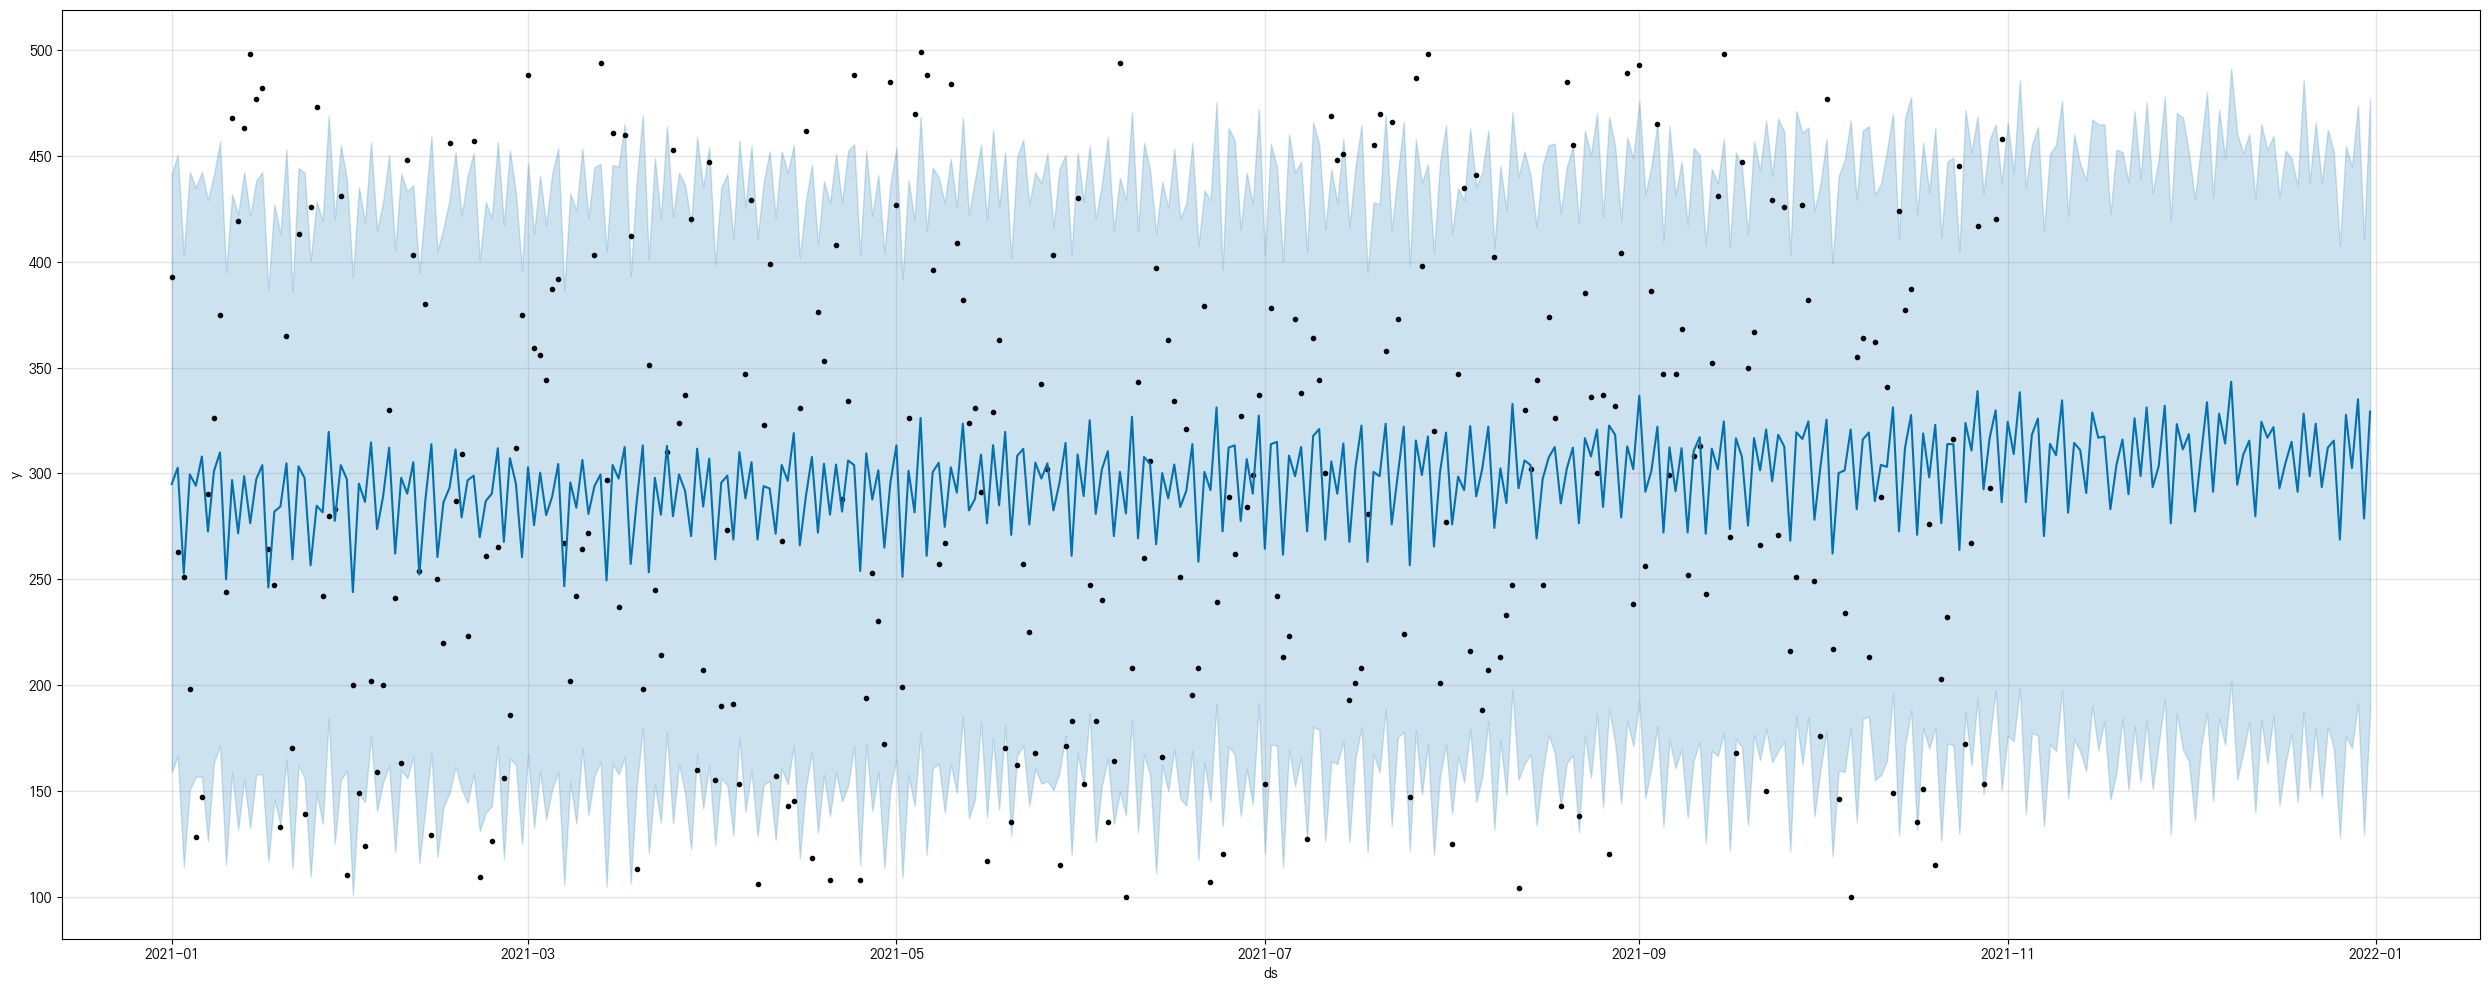

In [44]:
# 데이터 준비 (랜덤 데이터 생성)
df = pd.DataFrame({
    'ds': pd.date_range(start='2021-01-01', end='2021-10-31'),
    'y': np.random.randint(100, 500, size=len(pd.date_range(start='2021-01-01', end='2021-10-31')))
})

# 외부 변수 추가 (온도 데이터 생성)
df['temp'] = np.random.randint(10, 35, size=len(df))  # 10도에서 35도 사이의 랜덤 온도 값

# 모델 생성
model = Prophet()

# 외부 변수 추가
model.add_regressor('temp')

# 모델 학습
model.fit(df)

# 예측할 미래 날짜 생성 (연말까지 예측)
future = model.make_future_dataframe(periods=61)

# 미래 데이터에 외부 변수(temp) 추가
future['temp'] = np.random.randint(10, 35, size=len(future))  # 미래의 온도 값 추가

# 예측
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

회귀 분석에서 외부 변수 추가의 중요성: 외부 변수를 추가하는 이유는 예측의 정확도를 높이기 위해서입니다. 외부 변수는 시계열 패턴을 설명하는 데 도움을 주며, 예측 대상 변수와 상관관계가 있을 때 유용합니다. Prophet은 내부적으로 외부 변수와 예측 대상 간의 관계를 학습하여 예측에 반영합니다.

외부 변수의 효과: Prophet 모델에서 외부 변수를 추가하면, 이 변수의 변화가 예측에 어떻게 영향을 미치는지를 확인할 수 있습니다. 예를 들어, 온도가 예측 대상 변수에 영향을 미친다면, 온도가 높을 때 판매량이 증가하는 등의 패턴을 반영할 수 있습니다.

### ✅ 다변량 예측에서의 고려사항
- 회귀 변수의 중요성:
    - 외부 변수는 예측할 변수와 상관관계가 있어야 합니다. 예를 들어, 판매량과 온도는 상관관계가 있을 수 있습니다. 또한, 마케팅 비용과 판매량 간에도 관계가 있을 수 있습니다.
    - 상관관계가 약한 변수를 추가하면 모델의 성능이 오히려 낮아질 수 있기 때문에, 변수 선택이 매우 중요합니다.
- 외부 변수의 추가:
    - 외부 변수를 추가하면 예측 정확도를 높일 수 있습니다. 예를 들어, 광고비, 기온, 프로모션 이벤트 등의 변수가 판매량 예측에 중요한 영향을 미칠 수 있습니다.
    - 하지만 모든 외부 변수가 항상 유용한 것은 아니기 때문에, 적절한 변수 선택과 모델 튜닝이 중요합니다.
- 모델의 해석:
    - Prophet은 외부 변수를 회귀 분석처럼 다루기 때문에, 각 외부 변수가 예측에 얼마나 영향을 미치는지 확인할 수 있습니다. 예를 들어, 온도가 판매량에 미치는 영향 정도를 회귀 계수를 통해 해석할 수 있습니다.
 
### ✅ 다변량 예측의 실제 활용 예시
1. 판매량 예측 (판매량과 마케팅 예산)
    - 예를 들어, 마케팅 예산과 광고비가 판매량에 큰 영향을 미친다면, 이를 회귀 변수로 추가하여 판매량을 예측할 수 있습니다.
    - ```add_regressor()```를 통해 마케팅 예산을 추가하고, 이 변수의 영향을 예측할 수 있습니다.
2. 기후 예측 (기온과 에너지 소비량)
    - 기온이 에너지 소비량에 미치는 영향을 예측하려면, 기온을 외부 변수로 추가하여 에너지 소비량을 예측할 수 있습니다.
3. 고객 이탈 예측
    - 고객 이탈 예측에서는 고객 서비스, 프로모션 할인, 이용 빈도와 같은 외부 변수를 포함하여 예측 정확도를 높일 수 있습니다.
  
### ✅ 다변량 예측의 한계와 개선점
- 변수 간의 관계:
    - 모델에 추가하는 외부 변수들은 반드시 예측하고자 하는 주요 변수와 상관관계가 있어야 합니다.
    - 그렇지 않으면 성능이 저하될 수 있습니다.
- 추가적인 변수 조정:
    - 회귀 변수의 prior_scale을 통해 해당 변수의 민감도를 조절할 수 있습니다.
    - 이 값이 너무 높으면 해당 변수가 과도하게 반영될 수 있습니다.

### ✅ 결론
- Prophet은 단일 변수 예측 뿐만 아니라, 다수의 외부 변수를 추가하여 다변량 예측을 수행할 수 있습니다.
- 추가적인 변수들은 예측 성능을 크게 향상시킬 수 있으며, 회귀 변수를 통해 외부 요인을 모델에 반영할 수 있습니다.
- 하지만 각 변수의 상관관계와 적절한 선택이 중요합니다.
- 다변량 예측을 통해 예측 정확도를 높이고, 실제 비즈니스 의사결정에 유용한 정보를 제공할 수 있습니다. 

## 📌 2. 추세와 계절성의 세부 조정
- 이론적인 설명
    - 추세 (Trend): 시계열 데이터에서 추세는 시간이 지남에 따라 증가하거나 감소하는 패턴을 나타냅니다. Prophet은 기본적으로 선형 추세를 사용하지만, 비선형 추세를 모델링하려면 logistic 성장 모델을 사용할 수 있습니다.
    - 계절성 (Seasonality): 계절성은 시계열 데이터에서 주기적인 변화를 나타냅니다. 예를 들어, 일일, 주간, 연간 계절성이 있을 수 있습니다. Prophet은 기본적으로 연간과 주간 계절성을 지원하며, 사용자 정의 계절성을 추가할 수도 있습니다.
    - Changepoint: Prophet은 시계열 데이터에서 **추세 변화점(changepoint)** 을 자동으로 감지합니다. 이 변화점은 추세가 갑자기 바뀌는 지점을 나타내며, changepoint_prior_scale 파라미터를 사용하여 변화점 감지의 민감도를 조절할 수 있습니다.

2025-04-04 15:31:03,315 - INFO - Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
2025-04-04 15:31:03,315 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:31:03,320 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/5z9plqc3.json
2025-04-04 15:31:03,325 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/b7y7xre8.json
2025-04-04 15:31:03,325 - DEBUG - idx 0
2025-04-04 15:31:03,326 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:31:03,326 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92942', 'data', 'file=/tmp/tmp1zhw1ynh/5z9plqc3.json', 'init=/tmp/tmp1zhw1ynh/b7y7xre8.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelozy0cdv9/prophet_model-20250404153103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:03 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:31:03,326 - INFO - Chain [1

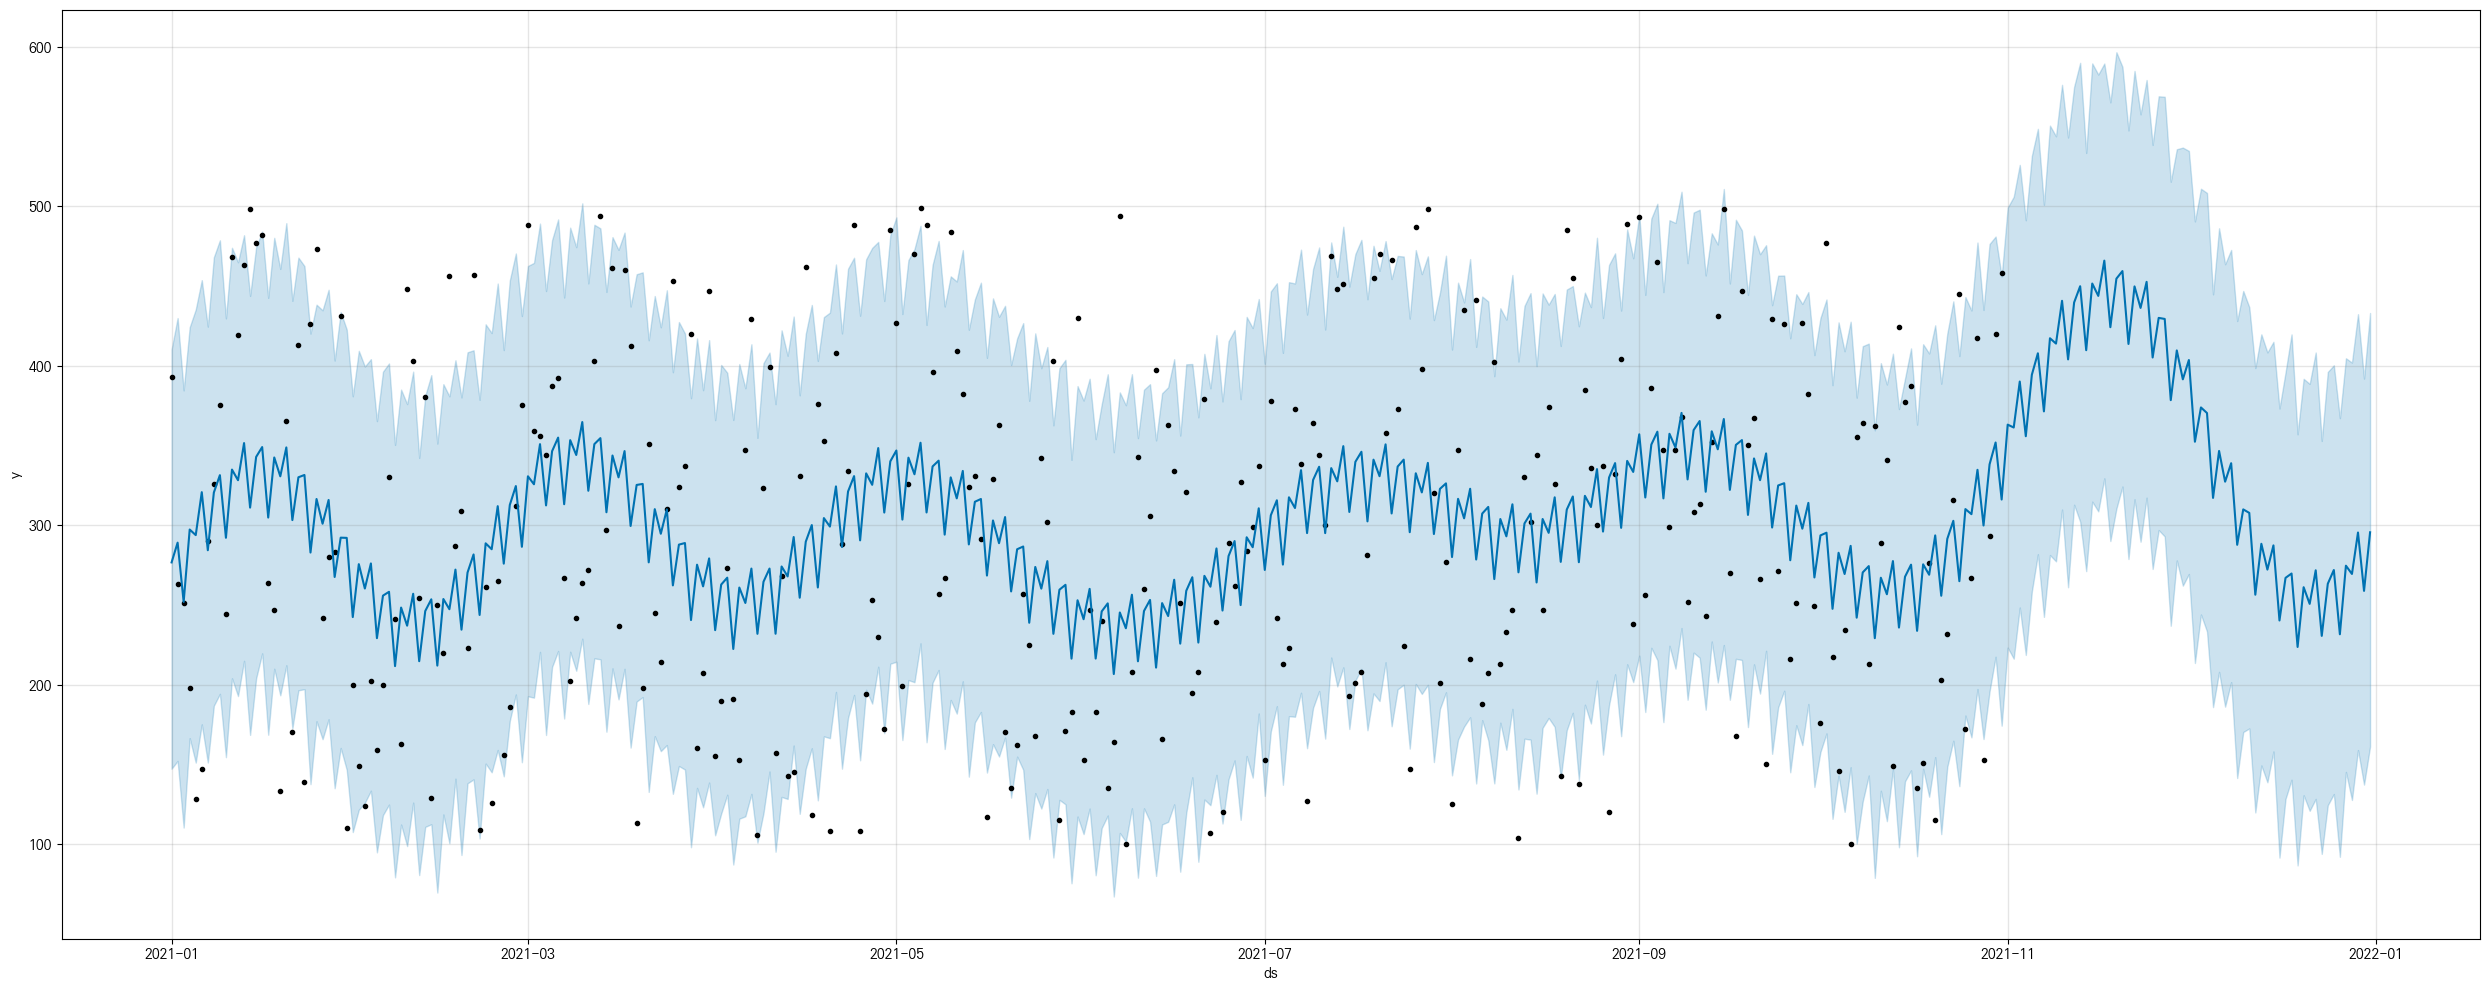

In [46]:
# 모델 생성
model = Prophet(
    changepoint_prior_scale=0.1,  # 추세 변화점 민감도 높임
    seasonality_prior_scale=10.0  # 계절성 민감도 높임
)

# 연간 계절성 추가 (기본적으로 활성화됨)
model.add_seasonality(name='yearly', period=365.25, fourier_order=8)

# 모델 학습
model.fit(df)

# 예측할 미래 날짜 생성 (연말까지 후 예측)
future = model.make_future_dataframe(periods=61)

# 예측
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

- 추세와 계절성 조정의 중요성: **changepoint_prior_scale** 와 **seasonality_prior_scale** 는 모델의 민감도를 조절하여 예측 정확도를 향상시킬 수 있습니다. 값이 커지면 모델은 추세 변화나 계절성을 더 민감하게 반영하게 되며, 이는 비즈니스나 현업에서 특정 시기나 이벤트에 대한 예측을 더 정확하게 만듭니다.

- 계절성의 커스터마이징: 연간, 월간, 주간 등의 계절성은 데이터에 맞게 조정할 수 있습니다. 예를 들어, 특정 비즈니스에서 월간 계절성을 더 강하게 반영할 필요가 있다면 Fourier 트랜스폼을 사용하여 Fourier order를 조정할 수 있습니다.

## 📌 3. 휴일 효과 및 이벤트 추가

- **휴일(Holidays)** 은 시계열 예측에 큰 영향을 미칠 수 있습니다. 예를 들어, 크리스마스, 설날, 블랙 프라이데이와 같은 큰 이벤트는 소비 패턴에 큰 영향을 미칩니다. 
- Prophet은 이러한 휴일 효과를 예측 모델에 반영할 수 있습니다.
- Prophet에서는 휴일 데이터를 입력받아 예측에 반영합니다. 이를 통해 예측된 날짜에 대한 정확도를 향상시킬 수 있습니다.

2025-04-04 15:35:40,176 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:35:40,177 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:35:40,183 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/79hcps9u.json
2025-04-04 15:35:40,187 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/5mczi1rj.json
2025-04-04 15:35:40,188 - DEBUG - idx 0
2025-04-04 15:35:40,188 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:35:40,188 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10778', 'data', 'file=/tmp/tmp1zhw1ynh/79hcps9u.json', 'init=/tmp/tmp1zhw1ynh/5mczi1rj.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelazpzf288/prophet_model-20250404153540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:40 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:35:40,188 - INFO - C

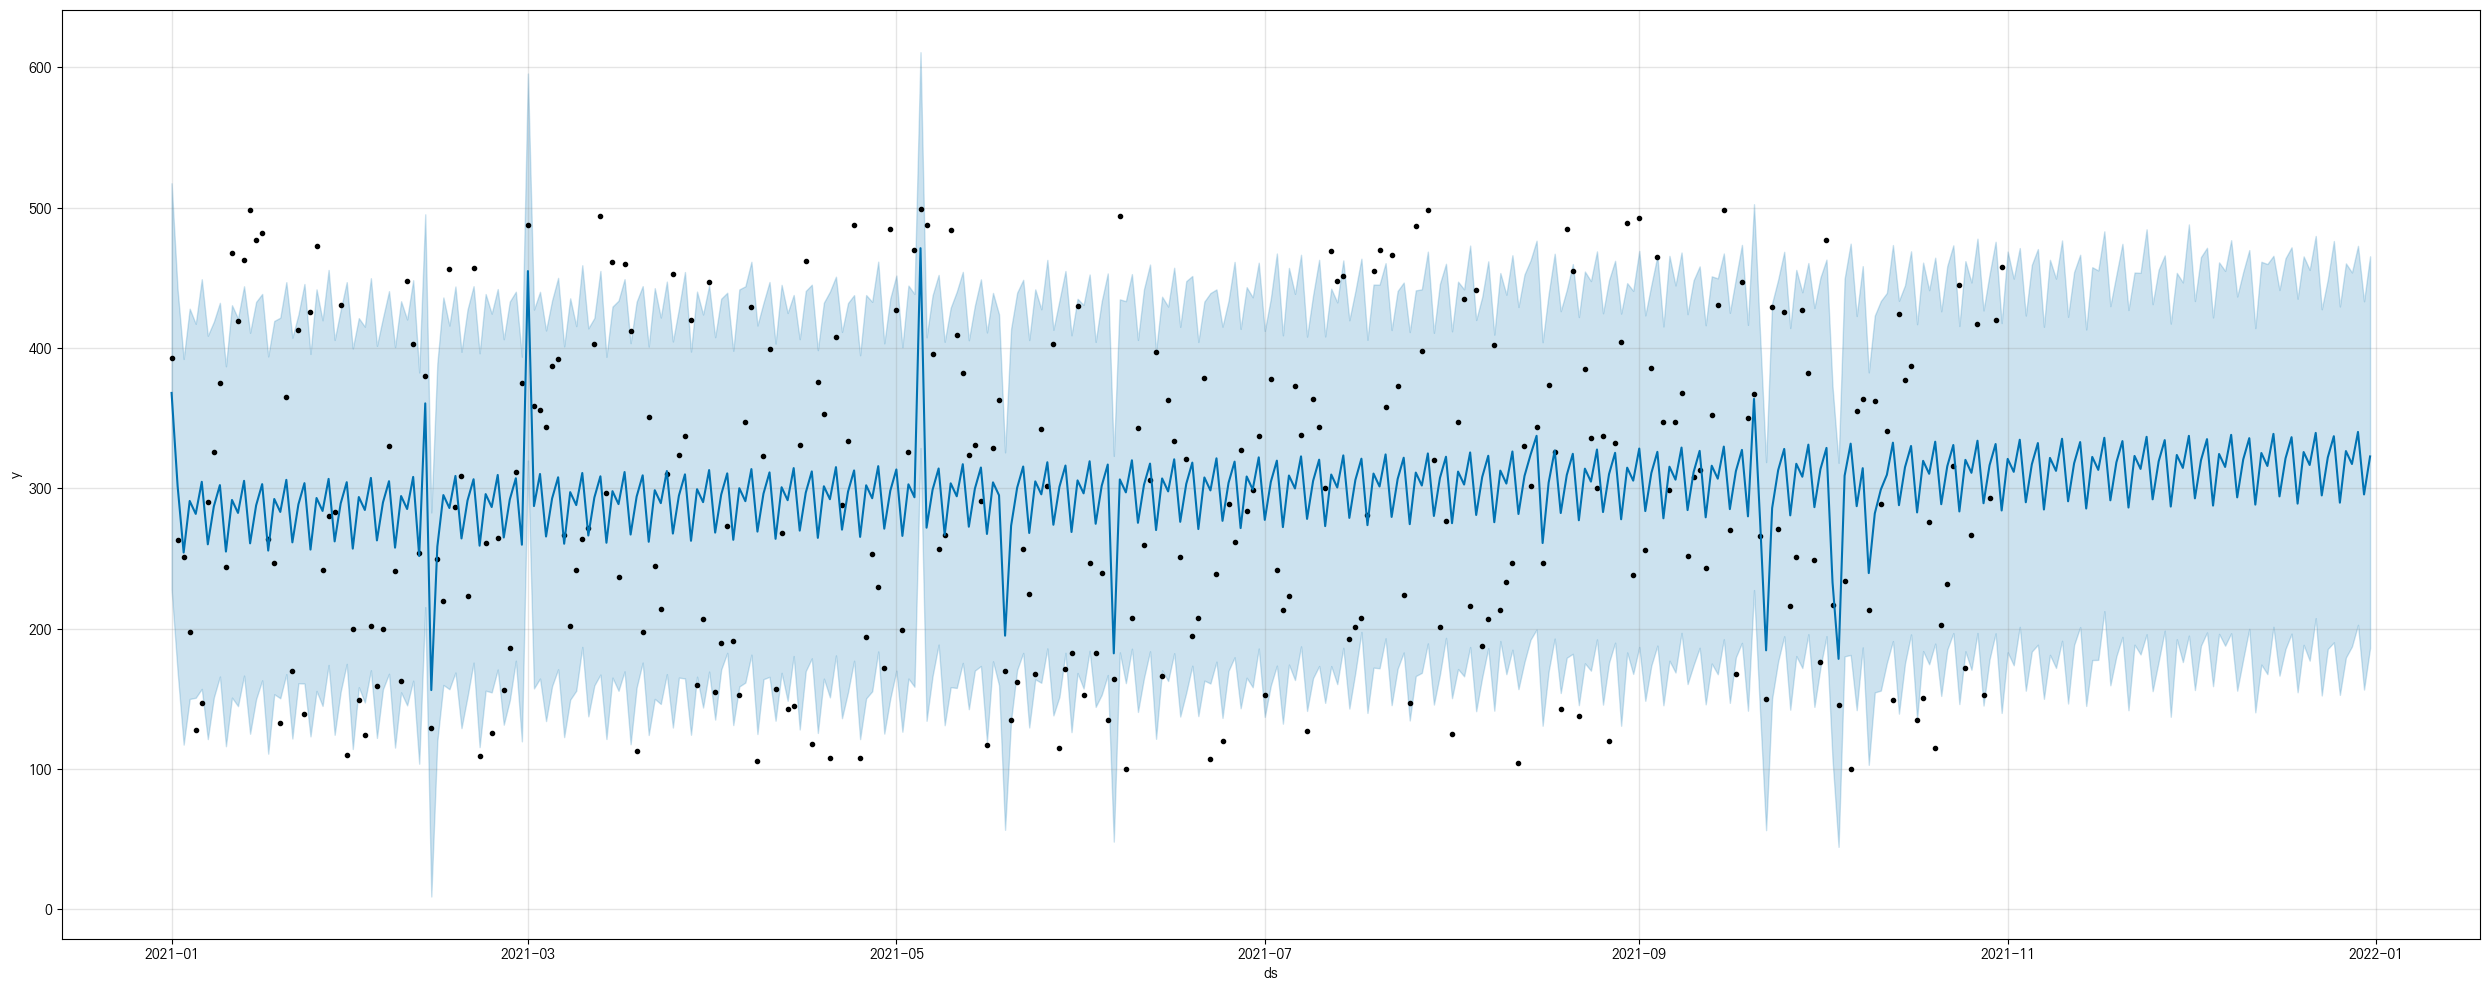

In [50]:
# 휴일 데이터 추가 (예: 크리스마스와 설날)
from prophet.make_holidays import make_holidays_df
holidays = make_holidays_df(year_list=[x for x in range(df['ds'].min().year, df['ds'].max().year+1)], country='KR')

# 모델 생성 (휴일 데이터 추가)
model = Prophet(holidays=holidays)

# 모델 학습
model.fit(df)

# 예측할 미래 날짜 생성 (30일 후 예측)
future = model.make_future_dataframe(periods=61)

# 예측
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

## 📌 4. 교차 검증 (Cross-validation)과 성능 평가
- 교차 검증 (Cross-validation): 교차 검증은 모델의 성능을 검증하는 중요한 방법입니다. Prophet에서는 주어진 시계열 데이터를 여러 부분으로 나누어, 학습과 검증을 반복하면서 모델의 성능을 평가할 수 있습니다. Prophet에서는 시계열 교차 검증을 위해 prophet.diagnostics.cross_validation()을 사용합니다.
- 성능 평가 지표: 시계열 모델에서 성능 평가를 위한 주요 지표는 여러 가지가 있습니다. Prophet에서는 MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), RMSE (Root Mean Squared Error) 등의 지표를 사용하여 예측 성능을 평가합니다.
    - MAE (Mean Absolute Error): 예측값과 실제값 간의 절대적 차이의 평균
    - MAPE (Mean Absolute Percentage Error): 예측값과 실제값 간의 백분율 차이의 평균
    - RMSE (Root Mean Squared Error): 예측값과 실제값 간의 차이의 제곱 평균을 구하고 그 제곱근을 취한 값으로, 예측 오차의 크기를 정량화합니다.

In [51]:
from prophet.diagnostics import cross_validation, performance_metrics

# Prophet 모델 생성
model = Prophet()

# 모델 학습
model.fit(df)

# 교차 검증 실행 (초기 180일 학습 후 30일 간격으로 예측)
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon='60 days')

# 성능 지표 계산
df_p = performance_metrics(df_cv)

# 성능 지표 출력
print(df_p)

2025-04-04 15:42:04,896 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:42:04,896 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:42:04,900 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/tjdrpv8s.json
2025-04-04 15:42:04,903 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/4k0k41te.json
2025-04-04 15:42:04,903 - DEBUG - idx 0
2025-04-04 15:42:04,903 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:42:04,903 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16421', 'data', 'file=/tmp/tmp1zhw1ynh/tjdrpv8s.json', 'init=/tmp/tmp1zhw1ynh/4k0k41te.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modele3twbz4m/prophet_model-20250404154204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:04 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:42:04,903 - INFO - C

  0%|          | 0/3 [00:00<?, ?it/s]

2025-04-04 15:42:04,918 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/lesrn7nr.json
2025-04-04 15:42:04,919 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/vwyblwrr.json
2025-04-04 15:42:04,920 - DEBUG - idx 0
2025-04-04 15:42:04,920 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:42:04,920 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55477', 'data', 'file=/tmp/tmp1zhw1ynh/lesrn7nr.json', 'init=/tmp/tmp1zhw1ynh/vwyblwrr.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_model3k9iis9s/prophet_model-20250404154204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:04 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:42:04,920 - INFO - Chain [1] start processing
15:42:04 - cmdstanpy - INFO - Chain [1] done processing
2025-04-04 15:42:04,924 - INFO - Chain [1] done processing
2025-04-04 15:42:04,946 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/219r8915.json
2025-04-04 15:42:04,

   horizon           mse        rmse         mae      mape     mdape  \
0   6 days  10690.707554  103.395878   91.159862  0.319474  0.300246   
1   7 days  10151.406654  100.754189   90.700353  0.328842  0.300246   
2   8 days   9497.729299   97.456294   85.876142  0.307580  0.216345   
3   9 days   7874.154512   88.736433   75.988468  0.290229  0.210372   
4  10 days  10485.333746  102.397919   83.607628  0.350304  0.210372   
5  11 days  10645.456278  103.176820   82.008918  0.297619  0.205189   
6  12 days   9156.604906   95.690151   72.578325  0.282403  0.205189   
7  13 days  10234.045629  101.163460   79.366255  0.299319  0.249277   
8  14 days  11663.474881  107.997569   87.284955  0.318138  0.298499   
9  15 days   9939.059091   99.694830   80.230251  0.301751  0.274113   
10 16 days   9186.718348   95.847370   77.908842  0.260269  0.274113   
11 17 days  12624.854117  112.360376   93.963006  0.324511  0.298499   
12 18 days  14696.015266  121.227123  106.252591  0.343430  0.29

- cross_validation(): initial, period, horizon 파라미터를 사용하여 교차 검증을 실행합니다.
    - initial: 학습 데이터의 초기 기간을 설정합니다. 예를 들어, '180 days'는 학습 데이터로 180일을 사용하겠다는 의미입니다.
    - period: 예측을 평가할 간격을 설정합니다. 예를 들어, '30 days'는 30일마다 예측을 평가합니다.
    - horizon: 예측의 기간을 설정합니다. 예를 들어, '60 days'는 60일 동안의 예측을 평가합니다.
- performance_metrics(): 교차 검증 결과에 대한 성능 지표를 계산합니다. MAE, MAPE, RMSE 등 다양한 지표를 제공하여 모델의 성능을 평가합니다.

- 교차 검증의 필요성: 시계열 모델에서는 과적합을 방지하는 것이 중요합니다. 과적합이란, 모델이 훈련 데이터에 너무 잘 맞춰져서 새로운 데이터에 대한 예측 성능이 떨어지는 현상입니다. 교차 검증은 모델이 새로운 데이터에 대해서도 잘 예측할 수 있는지를 확인하는 중요한 방법입니다.

- 성능 평가 지표의 해석:
    - MAE: 예측값과 실제값의 차이를 절대값으로 계산하여 평균을 낸 것입니다. 낮을수록 예측이 정확하다는 의미입니다.
    - MAPE: 백분율로 계산된 오차 평균입니다. 예측 정확도가 좋으면 MAPE가 낮습니다.
    - RMSE: 예측 오차의 제곱 평균의 제곱근으로, 예측값과 실제값의 차이를 제곱하여 평균한 뒤, 그 값을 제곱근으로 변환한 값입니다. 낮을수록 모델이 정확하다는 의미입니다.

## 📌 5. 고급 하이퍼파라미터 튜닝

- 하이퍼파라미터 (Hyperparameters): 하이퍼파라미터는 모델의 성능에 큰 영향을 미치는 변수로, 예를 들어 추세 변화점 민감도, 계절성 민감도, 휴일 민감도 등이 있습니다. Prophet에서 중요한 하이퍼파라미터로는 changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale 등이 있습니다.
- changepoint_prior_scale: 추세 변화점의 민감도를 설정하는 하이퍼파라미터입니다. 값이 크면 Prophet은 더 자주 추세 변화점을 감지하려고 시도합니다.
- seasonality_prior_scale: 계절성의 민감도를 설정하는 하이퍼파라미터입니다. 값이 크면 Prophet은 계절성 패턴을 더 강하게 반영하려고 합니다.
- holidays_prior_scale: 휴일 효과의 민감도를 설정하는 하이퍼파라미터입니다. 값이 크면 휴일 효과를 더 강하게 반영하려고 합니다.

2025-04-04 15:45:44,584 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:45:44,584 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:45:44,588 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/ft7_ncdt.json
2025-04-04 15:45:44,591 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/97yw5yra.json
2025-04-04 15:45:44,591 - DEBUG - idx 0
2025-04-04 15:45:44,591 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:45:44,591 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85746', 'data', 'file=/tmp/tmp1zhw1ynh/ft7_ncdt.json', 'init=/tmp/tmp1zhw1ynh/97yw5yra.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelpxz18qwd/prophet_model-20250404154544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:45:44,591 - INFO - C

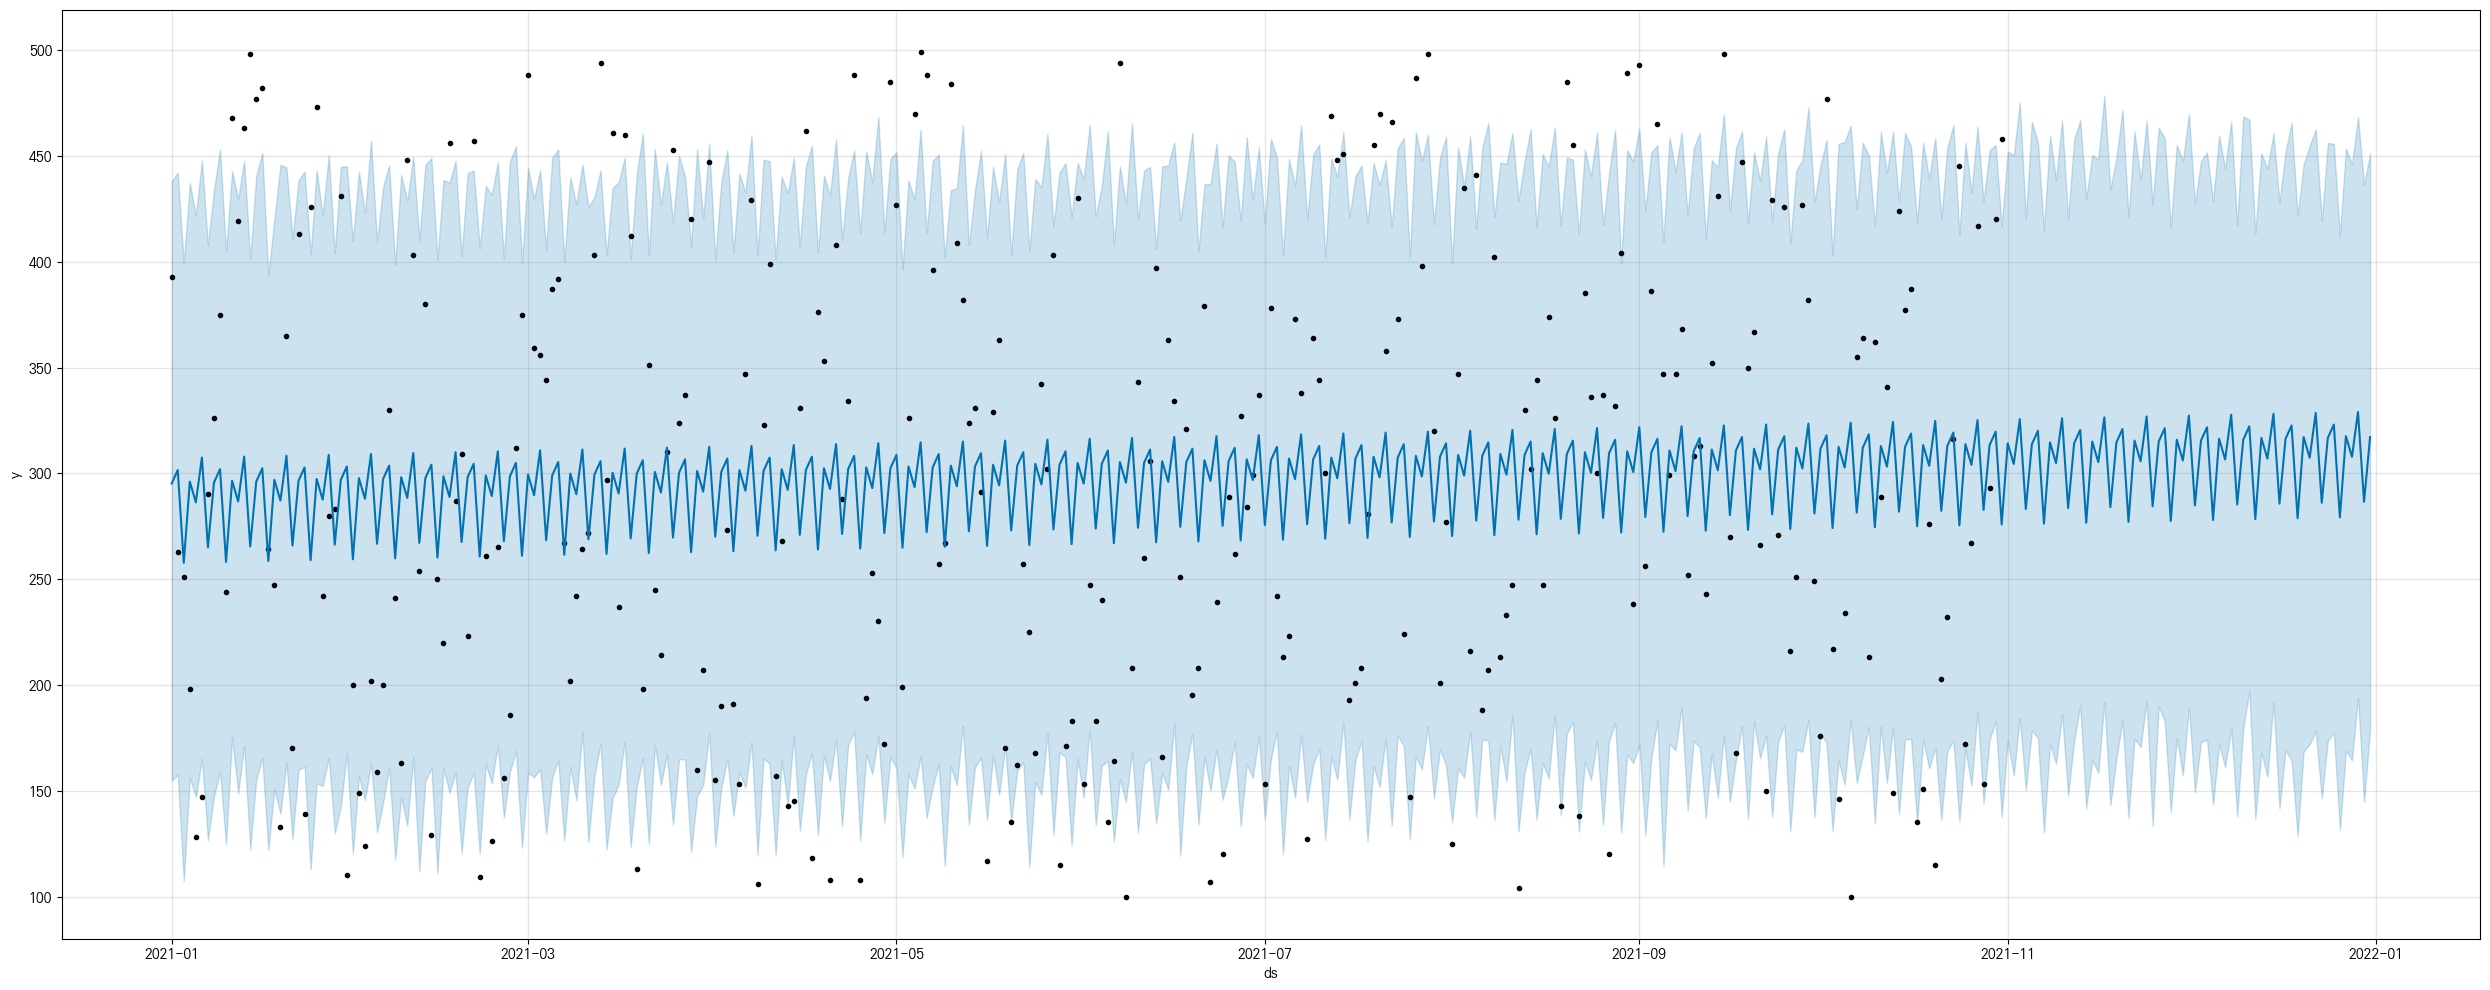

In [57]:
# 하이퍼파라미터 튜닝 (changepoint_prior_scale, seasonality_prior_scale 조정)
model = Prophet(
    changepoint_prior_scale=0.1,  # 추세 변화점 민감도 높임
    seasonality_prior_scale=20.0  # 계절성 민감도 높임
)

# 모델 학습
model.fit(df)

# 예측할 미래 날짜 생성 (연말까지 예측)
future = model.make_future_dataframe(periods=61)

# 예측
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

- changepoint_prior_scale와 seasonality_prior_scale를 조정하여 추세와 계절성의 민감도를 높였습니다. 이렇게 하여 추세 변화점과 계절성 패턴이 모델에 더 많이 반영되도록 설정했습니다.
- 하이퍼파라미터 튜닝의 중요성: 모델의 하이퍼파라미터를 적절히 튜닝하는 것이 예측 성능에 큰 영향을 미칩니다. 예를 들어, 추세 변화점 감지 민감도를 너무 높게 설정하면, 모델이 너무 많은 변화를 감지하여 과적합이 발생할 수 있습니다. 반대로 너무 낮게 설정하면 중요한 변화점을 놓칠 수 있습니다.
- 튜닝 방법: 하이퍼파라미터를 조정할 때는 교차 검증을 통해 성능을 평가하고, 가장 적합한 값을 찾아야 합니다. 이를 통해 모델을 최적화할 수 있습니다.



## 📌 6. 대규모 시계열 데이터 처리 및 성능 최적화
- 대규모 데이터 처리: Prophet은 대규모 시계열 데이터도 처리할 수 있지만, 데이터가 커질수록 모델 학습 시간과 예측 시간이 길어질 수 있습니다. 이때 성능 최적화를 통해 빠르고 효율적인 예측을 할 수 있습니다.
- 성능 최적화 방법:
    - 병렬 처리: 데이터가 매우 크면, Prophet은 내부적으로 병렬 처리를 통해 예측 성능을 향상시킬 수 있습니다.
    - 샘플링: 데이터 샘플링을 통해 전체 데이터를 다 사용하지 않고 일부 샘플 데이터를 사용하여 Prophet 모델을 학습시킬 수 있습니다.

2025-04-04 15:54:17,175 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:54:17,176 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:54:17,180 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/812q0xz_.json
2025-04-04 15:54:17,182 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/0n1jpaav.json
2025-04-04 15:54:17,182 - DEBUG - idx 0
2025-04-04 15:54:17,183 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:54:17,183 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25848', 'data', 'file=/tmp/tmp1zhw1ynh/812q0xz_.json', 'init=/tmp/tmp1zhw1ynh/0n1jpaav.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelc3rcnxx1/prophet_model-20250404155417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:17 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:54:17,183 - INFO - C

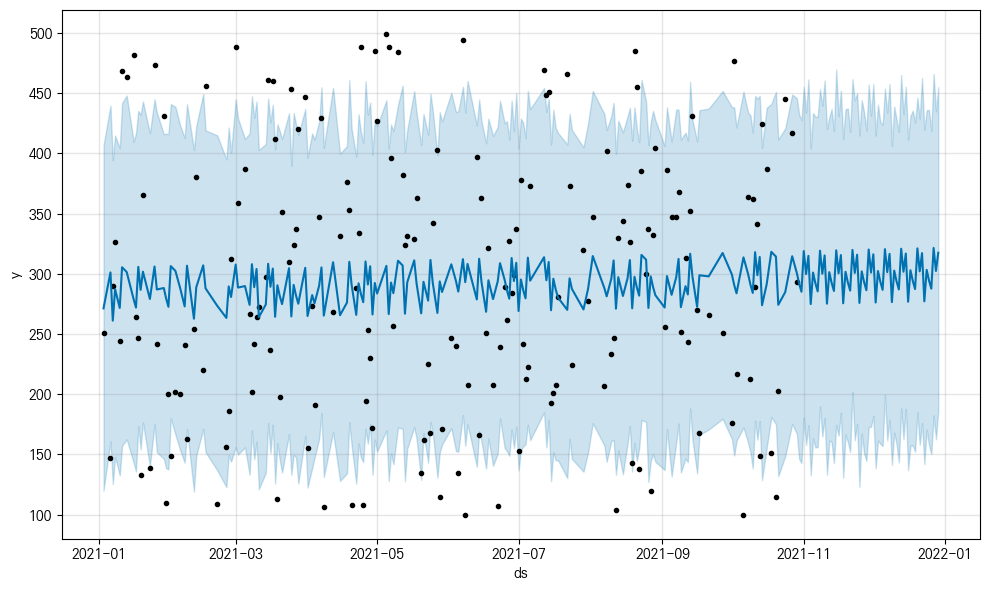

In [63]:
# 데이터 샘플링
df_sampled = df.sample(frac=0.6, random_state=42)  # 10% 샘플링

# 모델 학습 (샘플 데이터로)
model = Prophet()
model.fit(df_sampled)

# 예측할 미래 날짜 생성 (30일 후 예측)
future = model.make_future_dataframe(periods=61)

# 예측
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast)
plt.show()

# Prophet 모델 생성 시 주요 파라미터
Prophet() 모델을 생성할 때 사용할 수 있는 여러 가지 파라미터가 있습니다. 각 파라미터는 모델의 성격과 예측을 어떻게 다룰지에 큰 영향을 미칩니다.

## 1. growth
- 설명: growth는 데이터의 추세가 선형인지 로지스틱인지를 결정합니다.
- 가능한 값:
    - 'linear': 기본값. 선형 추세를 사용합니다.
    - 'logistic': 로지스틱 성장을 사용합니다. 주로 제한된 자원(예: 인구 수, 판매 수량 등)에 대해 예측할 때 사용됩니다.
```model = Prophet(growth='logistic')```

## 2. changepoint_prior_scale
- 설명: 이 파라미터는 추세 변화점(changepoint)의 민감도를 설정합니다. 추세 변화점은 데이터에서 추세가 급격하게 변화하는 지점을 찾는 데 사용됩니다.
    - 값이 크면: Prophet은 더 자주 추세 변화점을 감지하려고 시도합니다.
    - 값이 작으면: 변화점을 덜 민감하게 감지하고, 추세를 더 부드럽게 모델링합니다.
- 기본값: 0.05
```model = Prophet(changepoint_prior_scale=0.1)```

## 3. changepoint_range
- 설명: 추세 변화점을 탐지할 수 있는 데이터의 비율을 설정합니다. 0에서 1 사이의 값으로 설정할 수 있으며, 1은 전체 데이터에서 추세 변화점을 감지하려는 범위를 의미합니다.
- 기본값: 0.8 (80%의 데이터에서 변화점 탐지)

```model = Prophet(changepoint_range=0.9)```

## 4. yearly_seasonality
- 설명: 연간 계절성을 모델에 추가할지 여부를 설정합니다.
- 가능한 값:
    - True (기본값): 연간 계절성을 사용합니다.
    - False: 연간 계절성을 사용하지 않습니다.
    - int 또는 list: 사용자 정의 Fourier 항 수를 설정할 수 있습니다. fourier_order와 결합해서 사용할 수 있습니다.
```model = Prophet(yearly_seasonality=True)```

## 5. weekly_seasonality
- 설명: 주간 계절성을 모델에 추가할지 여부를 설정합니다.
- 가능한 값:
    - True (기본값): 주간 계절성을 사용합니다.
    - False: 주간 계절성을 사용하지 않습니다.
    - int 또는 list: 사용자 정의 Fourier 항 수를 설정할 수 있습니다.
```model = Prophet(weekly_seasonality=True)```

## 6. daily_seasonality
- 설명: 일간 계절성을 모델에 추가할지 여부를 설정합니다.
- 가능한 값:
    - True: 일간 계절성을 사용합니다.
    - False (기본값): 일간 계절성을 사용하지 않습니다.
```model = Prophet(daily_seasonality=True)```

## 7. holidays
- 설명: 특정 휴일(또는 이벤트)의 영향을 모델에 추가하는 파라미터입니다. 휴일 효과를 반영하여 예측을 더 정확하게 할 수 있습니다.
- 형식: DataFrame 형식으로 휴일 정보를 전달합니다. holiday(휴일 이름), ds(휴일 날짜), lower_window(휴일 전후 기간), upper_window(휴일 전후 기간)을 포함합니다.
```model = Prophet(holidays=holidays)```

## 8. seasonality_mode
- 설명: 계절성 모델을 어떻게 다룰지 설정합니다.
- 가능한 값:
    - 'additive': 계절성의 영향이 데이터에 더해지는 형태입니다.
    - 'multiplicative': 계절성이 데이터를 곱하는 형태로 적용됩니다.
- 기본값: 'additive'
```model = Prophet(seasonality_mode='multiplicative')```

## 9. seasonality_prior_scale
- 설명: 계절성의 민감도를 설정하는 파라미터입니다.
- 기본값: 10.0
- 값이 크면: 계절성이 더 강하게 반영됩니다.
- 값이 작으면: 계절성 효과가 덜 반영됩니다.
```model = Prophet(seasonality_prior_scale=15.0)```


## 10. holidays_prior_scale
- 설명: 휴일 효과의 민감도를 설정하는 파라미터입니다.
- 기본값: 10.0
```model = Prophet(holidays_prior_scale=15.0)```


## 11. interval_width
- 설명: 예측 값의 신뢰 구간을 설정하는 파라미터입니다. 예측 결과의 상한과 하한을 결정하는데 사용됩니다.
- 기본값: 0.80 (80% 신뢰 구간)
```model = Prophet(interval_width=0.95)```

## 12. stan_backend
- 설명: Prophet은 모델을 훈련할 때 Stan을 사용합니다. 이 파라미터를 통해 Stan의 백엔드를 설정할 수 있습니다.
- 가능한 값:
    - 'CMDSTANPY': cmdstanpy를 사용하는 방법 (기본값)
    - 'PYSTAN': pystan을 사용하는 방법
```model = Prophet(stan_backend='CMDSTANPY')```

## uncertainty_samples
- 예측 시 불확실성 샘플을 얼마나 생성할지 설정합니다.
- 이를 통해 예측에 대한 불확실성을 확인할 수 있습니다.
- 기본값: 1000 (1000개의 샘플을 사용)
```model = Prophet(uncertainty_samples=500)```

2025-04-04 17:18:54,596 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 17:18:54,597 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 17:18:54,602 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/sji44f5o.json
2025-04-04 17:18:54,605 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/kn3z0voe.json
2025-04-04 17:18:54,605 - DEBUG - idx 0
2025-04-04 17:18:54,605 - DEBUG - running CmdStan, num_threads: None
2025-04-04 17:18:54,605 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17508', 'data', 'file=/tmp/tmp1zhw1ynh/sji44f5o.json', 'init=/tmp/tmp1zhw1ynh/kn3z0voe.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modeljwbxxlxm/prophet_model-20250404171854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:54 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 17:18:54,605 - INFO - C

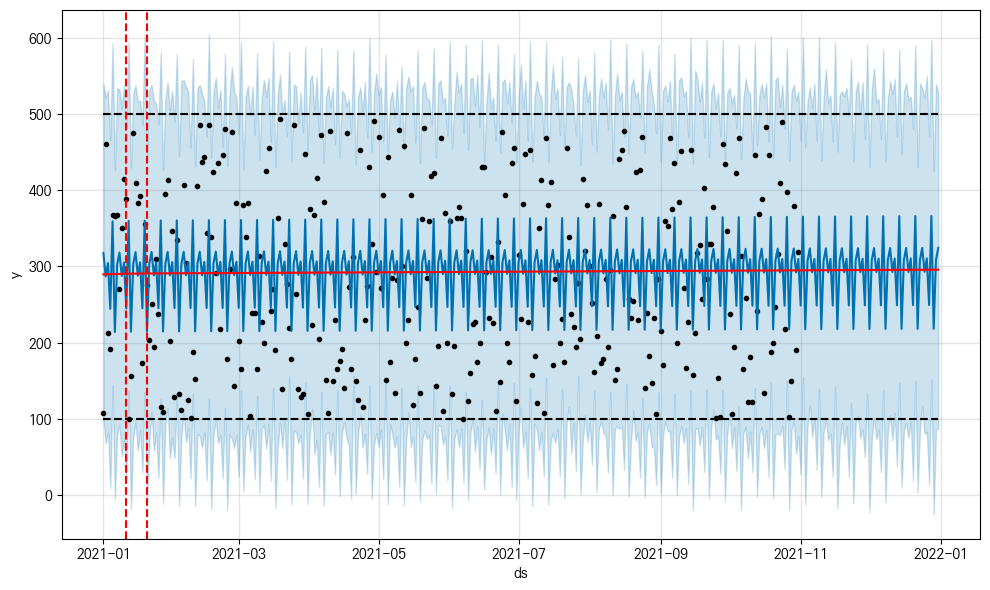

In [72]:
import pandas as pd
from prophet import Prophet

# 예시 데이터
df = pd.DataFrame({
    'ds': pd.date_range(start='2021-01-01', end='2021-10-31'),
    'y': np.random.randint(100, 500, size=len(pd.date_range(start='2021-01-01', end='2021-10-31')))
})
# cap (상한) 값 추가
df['cap'] = 500  # 예시로 상한을 500으로 설정
# floor (하한) 값 추가
df['floor'] = 100  # 예시로 하한을 100으로 설정

# 휴일 데이터 (예시)
holidays = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2021-12-25', '2022-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# 모델 생성
model = Prophet(
    growth='logistic', 
    changepoint_prior_scale=0.1, 
    seasonality_prior_scale=10.0,
    holidays=holidays,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

# 모델 학습
model.fit(df)

# 예측할 미래 날짜 생성
future = model.make_future_dataframe(periods=61)
# cap (상한) 값 추가
future['cap'] = 500  # 예시로 상한을 500으로 설정
# floor (하한) 값 추가
future['floor'] = 100  # 예시로 하한을 100으로 설정
# 예측
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast)
# 변화점 추가 (추세가 바뀌는 지점 표시)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

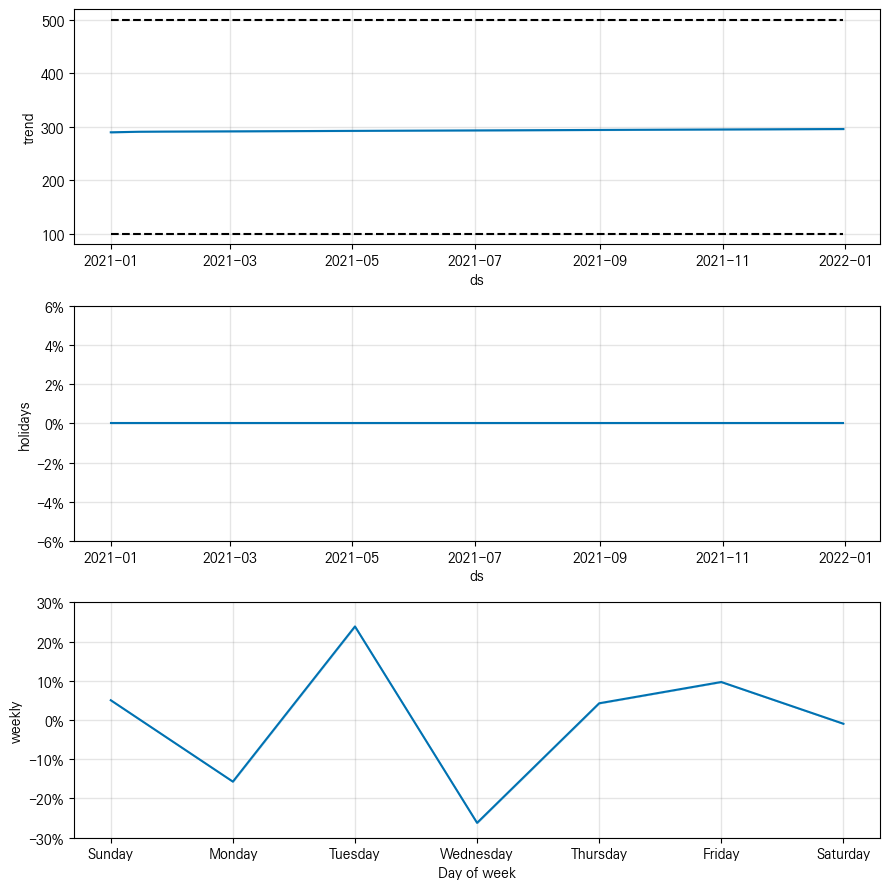

In [75]:
model.plot_components(forecast);

# Prophet 예측 차트 해석 방법

1. 실제 데이터 (Black dots / Black line)
- 의미: 이 부분은 모델이 학습한 실제 데이터를 나타냅니다. 실제 값은 검은색 점으로 표시됩니다.
- 해석: 예측 모델이 학습하는 동안, 과거의 값들을 확인할 수 있습니다. 이를 통해 예측하고자 하는 값의 패턴과 변화를 이해할 수 있습니다.

2. 예측값 (Blue line - yhat)
- 의미: **파란색 선** 은 Prophet 모델이 예측한 미래 값을 나타냅니다. Prophet은 과거 데이터를 기반으로 미래에 발생할 수 있는 값을 예측합니다.
- 해석: 이 선은 모델이 예측한 미래의 트렌드를 나타냅니다. 예측값이 실제 데이터와 얼마나 일치하는지에 따라 모델의 예측 성능을 판단할 수 있습니다.

3. 신뢰 구간 (Shaded Area - yhat_lower, yhat_upper)
- 의미: 예측값에는 불확실성이 존재합니다. Prophet은 예측값을 신뢰 구간으로 나타냅니다. 이 신뢰 구간은 예측값이 실제로 그 구간 안에 있을 확률이 높다는 것을 의미합니다.
- 신뢰 구간은 회색 음영 영역으로 표시됩니다:
    - yhat_lower: 예측값의 하한
    - yhat_upper: 예측값의 상한
- 해석: 이 영역은 모델이 예측하는 미래 값에 대해 얼마나 불확실한지를 나타냅니다. 
    - 좁은 신뢰구간 : 예측값에 대한 **불확실성이 적다** 는 의미
    - 넓은 신뢰구간 : 예측값에 대한 **불확실성이 크다** 는 의미

4. 추세 변화점 (Changepoints - Red Dots)
- 의미: Prophet 모델은 데이터에서 추세가 급격히 변하는 시점을 자동으로 찾아냅니다. 이 시점을 **변화점(changepoint)** 이라고 하며, 그래프에서 빨간 점으로 표시됩니다.
- 해석: 추세 변화점은 모델이 과거 데이터의 변화를 감지한 지점입니다.
    - 예를 들어, 판매량이 갑자기 증가하거나 감소하는 시점, 기후가 급변하는 시점 등이 될 수 있습니다.
    - 이 지점들은 비즈니스에서 급격한 변화가 발생하는 시점일 수 있으므로 주의 깊게 분석해야 합니다.